# Temperature data

## Import libraries

In [1]:
"""Basic ones"""
import polars as pl
from plotnine import *
import matplotlib.pyplot as plt
plt.show()  # for display figures after ggplot
# plt.rcParams['axes.grid'] = True
import numpy as np
import seaborn as sns
import pandas
import statsmodels.api as sm
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

/home/kota/anaconda3/envs/bayes/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4


## Load data

- 平均気温(℃)
- 最高気温(℃)
- ~~最高気温(℃)時分~~
- 最低気温(℃)
- ~~最低気温(℃)時分~~

In [2]:
file_name = "../../data/weather/temperature.csv"
df = pl.read_csv(file_name, encoding="shift-jis", skip_rows=3)
display(df.columns)
df.columns = ["date", "day_of_week", "mean_temperature", "max_temperature", "max_temperature_time", \
                "min_temperature", "min_temperature_time"]
df = df.with_columns(pl.col("date").str.strptime(pl.Date, "%Y/%m/%d")) # convert day column data type into date type
df = (
    df.with_columns(pl.col(["max_temperature_time", "min_temperature_time"]).str
                    .strptime(pl.Datetime, "%Y/%m/%d %H:%M")) # convert time column data type into datetime
)
df.head()

['年月日', '曜日', '平均気温(℃)', '最高気温(℃)', '最高気温(℃)時分', '最低気温(℃)', '最低気温(℃)時分']

date,day_of_week,mean_temperature,max_temperature,max_temperature_time,min_temperature,min_temperature_time
date,str,f64,f64,datetime[μs],f64,datetime[μs]
2017-07-01,"""土""",22.5,25.1,2017-07-01 12:52:00,20.3,2017-07-02 00:00:00
2017-07-02,"""日""",23.3,29.2,2017-07-02 11:20:00,20.3,2017-07-02 00:02:00
2017-07-03,"""月""",24.1,29.3,2017-07-03 15:51:00,21.7,2017-07-03 09:26:00
2017-07-04,"""火""",22.0,24.2,2017-07-04 14:58:00,20.1,2017-07-04 05:35:00
2017-07-05,"""水""",23.6,27.8,2017-07-05 13:42:00,20.6,2017-07-06 00:00:00


## Check nulls

In [3]:
display(df.null_count())

nulls = df.hstack(df.transpose().select(pl.all().is_null().sum()).transpose().rename({"column_0": "null_count"}))
nulls.filter(pl.col("null_count") != 0)

date,day_of_week,mean_temperature,max_temperature,max_temperature_time,min_temperature,min_temperature_time
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0


date,day_of_week,mean_temperature,max_temperature,max_temperature_time,min_temperature,min_temperature_time,null_count
date,str,f64,f64,datetime[μs],f64,datetime[μs],u32


## Visualization

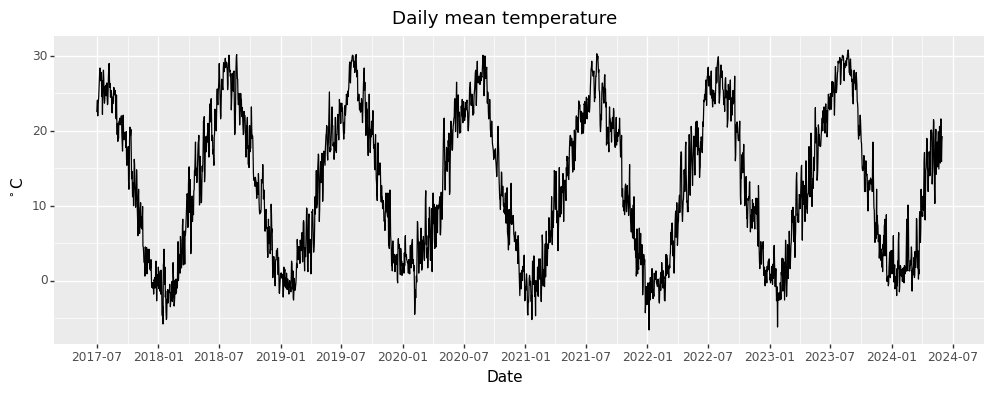

<ggplot: (8786658077916)>

In [4]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="mean_temperature"))
    + labs(title="Daily mean temperature", x="Date", y="$^\circ$C")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

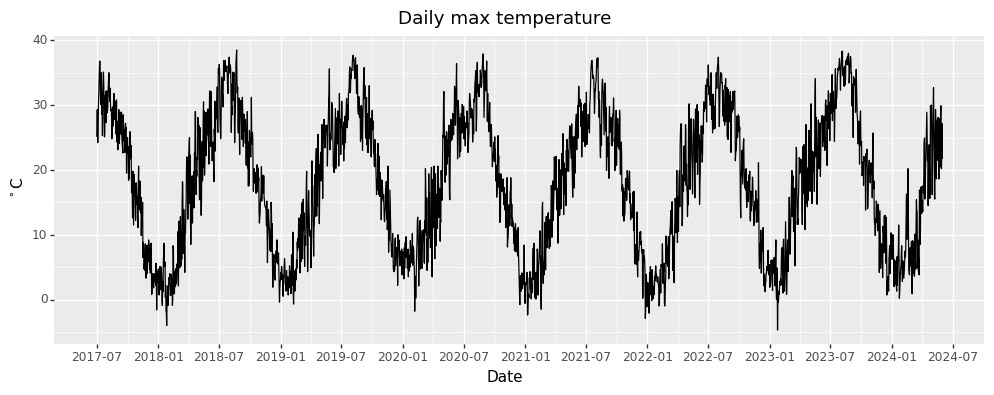

<ggplot: (8786658091867)>

In [5]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="max_temperature"))
    + labs(title="Daily max temperature", x="Date", y="$^\circ$C")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

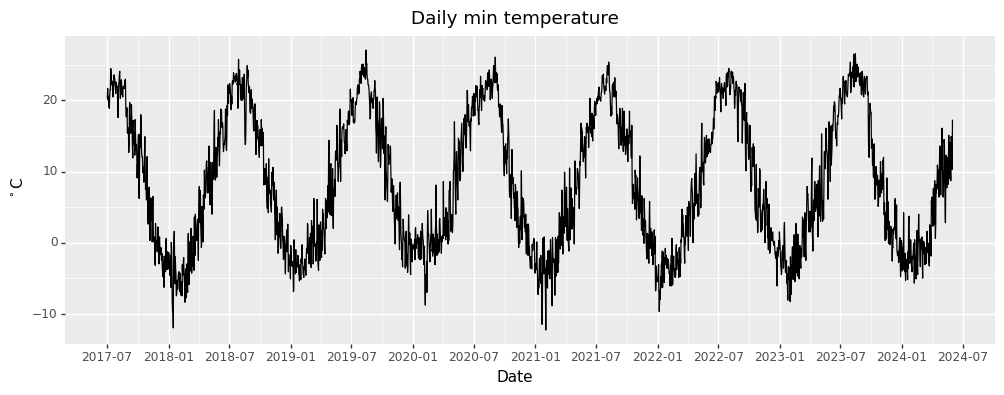

<ggplot: (8786634283756)>

In [6]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="min_temperature"))
    + labs(title="Daily min temperature", x="Date", y="$^\circ$C")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

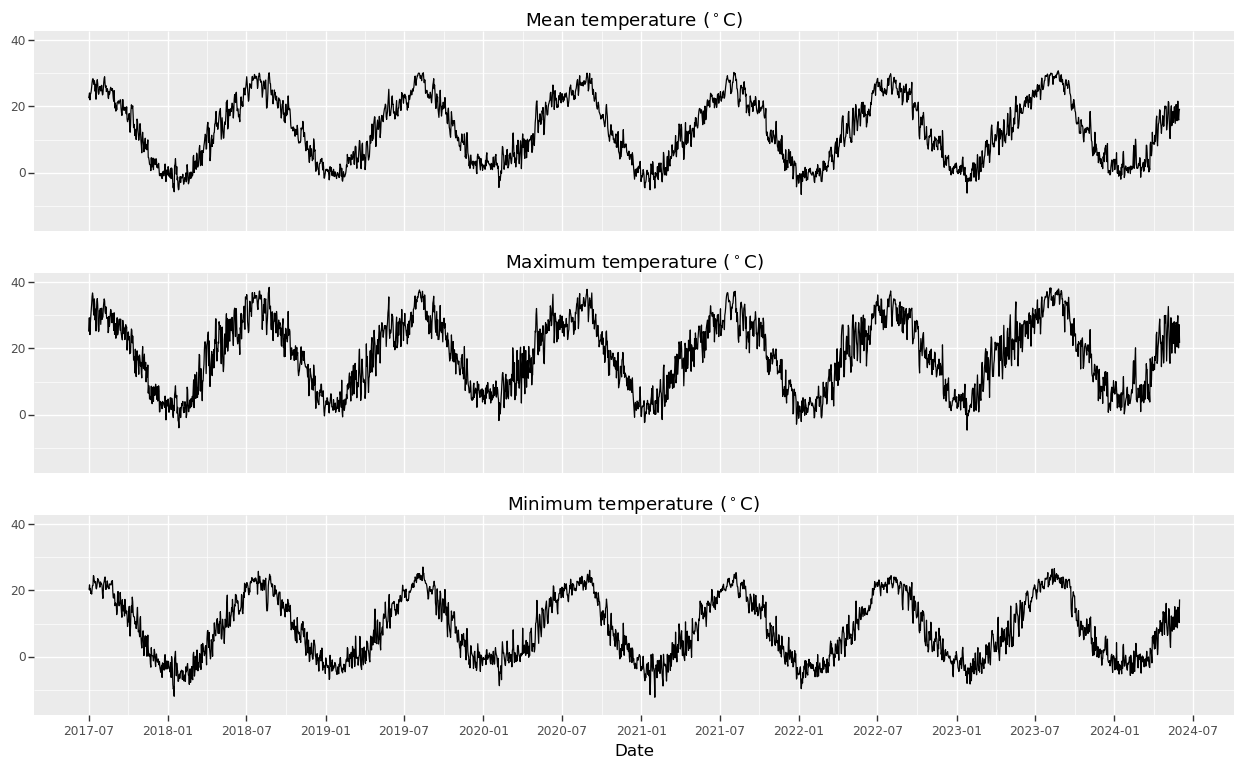

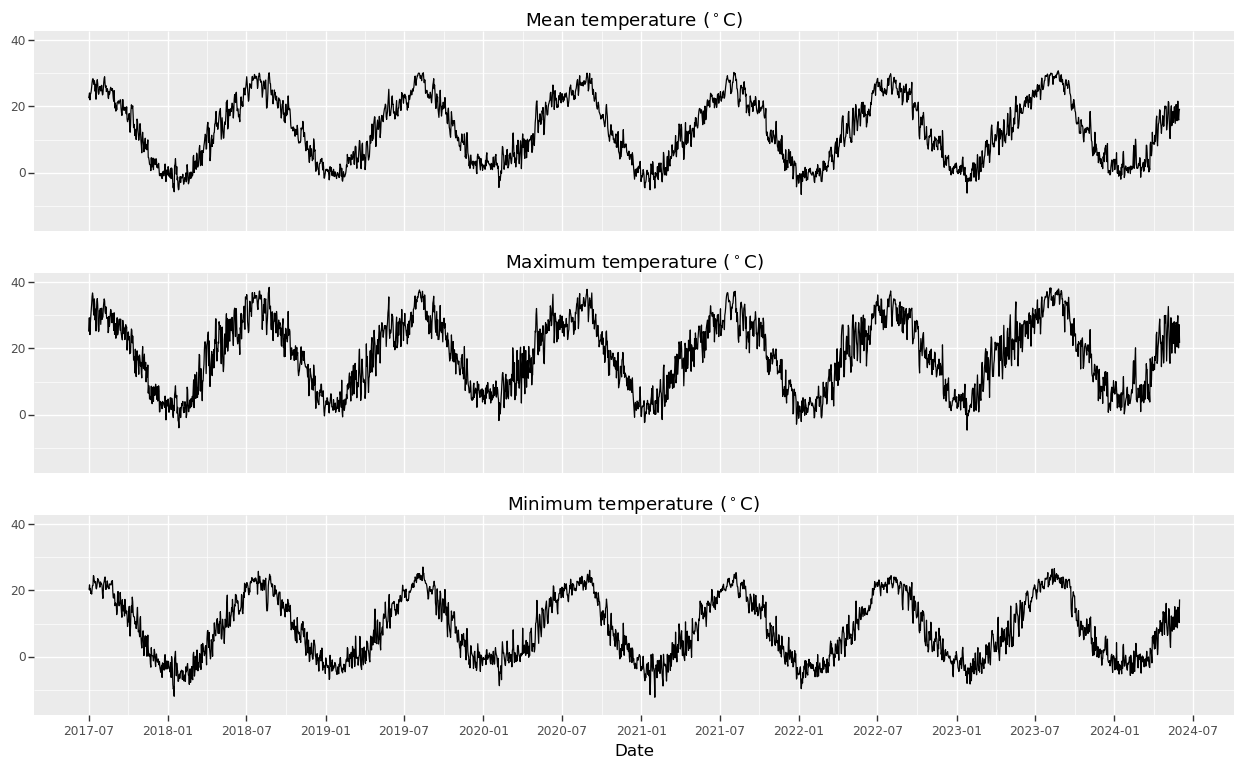

In [7]:
# https://github.com/has2k1/plotnine/issues/46
import patchworklib as pw


g1 = pw.load_ggplot(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="mean_temperature"))
    + labs(title="Mean temperature ($^\circ$C)", x="Date", y="")
    + theme(figure_size=(12, 2), axis_title_x=element_blank(), axis_ticks_major_x=element_blank()
            , axis_ticks_minor_x=element_blank(), axis_text_x=element_blank())
    + scale_x_date(
        date_labels="%Y-%m",
        date_breaks="6 month",
    )
    + ylim(-15, 40)
)

g2 = pw.load_ggplot(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="max_temperature"))
    + labs(title="Maximum temperature ($^\circ$C)", x="Date", y="")
    + theme(figure_size=(12, 2), axis_title_x=element_blank(), axis_ticks_major_x=element_blank()
            , axis_ticks_minor_x=element_blank(), axis_text_x=element_blank())
    + scale_x_date(
        date_labels="%Y-%m",
        date_breaks="6 month",
    )
    + ylim(-15, 40)
)

g3 = pw.load_ggplot(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="min_temperature"))
    + labs(title="Minimum temperature ($^\circ$C)", x="Date", y="")
    + theme(figure_size=(12, 2))
    + scale_x_date(
        date_labels="%Y-%m",
        date_breaks="6 month",
    )
    + ylim(-15, 40)
)

# By specifying g3 in (g3|g2), g1 is positioned exactly on g3.
pw.param["margin"] = 0.2
(
    g1 / g2 / g3
).savefig(fname="../../fig/weather/tempreture.png", dpi=500)
